In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='cennosti.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/sony/,NaN,Мир,Sony выдает лицензии на использование технолог...,Корпорация Sony выдала лицензии на использован...,Ценности,корпорация sony выдать лицензия использование ...
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/vodka/,NaN,Экономика,"В Уфе выпустили водку ""Беспохмельную""","Уфимский спиртоводочный комбинат ""Золотой век""...",Ценности,уфимский спиртоводочный комбинат золотой век о...
2,1999-10-15 12:00:00,https://lenta.ru/news/1999/10/15/sun/,NaN,Экономика,Доходы Sun возросли на 25%,Доходы Sun Microsystems Inc. за III квартал эт...,Ценности,доход sun microsystems inc iii квартал увеличи...
3,1999-10-25 12:00:00,https://lenta.ru/news/1999/10/25/primakov/,NaN,Россия,В Москве появились антипримаковские листовки,Листовки с карикатурами на Евгения Примакова и...,Ценности,листовка карикатура евгений примаков надпись п...
4,1999-12-03 12:00:00,https://lenta.ru/news/1999/12/03/film/,NaN,Интернет и СМИ,Три киношколы организуют виртуальную четвертую,"Три учреждения, располагающиеся на трех разных...",Ценности,учреждение располагаться разный континент scho...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/sony/,NaN,Мир,Sony выдает лицензии на использование технолог...,Корпорация Sony выдала лицензии на использован...,Ценности,корпорация sony выдать лицензия использование ...,"[корпорация, sony, выдать, лицензия, использов..."
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/vodka/,NaN,Экономика,"В Уфе выпустили водку ""Беспохмельную""","Уфимский спиртоводочный комбинат ""Золотой век""...",Ценности,уфимский спиртоводочный комбинат золотой век о...,"[уфимский, спиртоводочный, комбинат, золотой, ..."
2,1999-10-15 12:00:00,https://lenta.ru/news/1999/10/15/sun/,NaN,Экономика,Доходы Sun возросли на 25%,Доходы Sun Microsystems Inc. за III квартал эт...,Ценности,доход sun microsystems inc iii квартал увеличи...,"[доход, sun, microsystems, inc, iii, квартал, ..."
3,1999-10-25 12:00:00,https://lenta.ru/news/1999/10/25/primakov/,NaN,Россия,В Москве появились антипримаковские листовки,Листовки с карикатурами на Евгения Примакова и...,Ценности,листовка карикатура евгений примаков надпись п...,"[листовка, карикатура, евгений, примаков, надп..."
4,1999-12-03 12:00:00,https://lenta.ru/news/1999/12/03/film/,NaN,Интернет и СМИ,Три киношколы организуют виртуальную четвертую,"Три учреждения, располагающиеся на трех разных...",Ценности,учреждение располагаться разный континент scho...,"[учреждение, располагаться, разный, континент,..."


### Модель

In [12]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 1.39 s, sys: 4.11 ms, total: 1.4 s
Wall time: 1.41 s


In [13]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 1.07 s, sys: 55.7 ms, total: 1.13 s
Wall time: 1.16 s


In [14]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.616479720378171
Coherence Score: 0.5907428567164666
CPU times: user 4min 21s, sys: 596 ms, total: 4min 21s
Wall time: 3min 58s


### Топ-топики в текстах

In [15]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 39.3 s, sys: 80.2 ms, total: 39.4 s
Wall time: 39.6 s


In [16]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9952,"модель, миллион","[корпорация, sony, выдать, лицензия, использов..."
1,1,1.0,0.4403,новый,"[уфимский, спиртоводочный, комбинат, золотой, ..."
2,2,1.0,0.9338,"миллион, доллар, продажа","[доход, sun, microsystems, inc, iii, квартал, ..."
3,3,0.0,0.5996,,"[листовка, карикатура, евгений, примаков, надп..."
4,4,0.0,0.3273,,"[учреждение, располагаться, разный, континент,..."
5,5,1.0,0.7648,,"[строительный, фирма, mabetex, engineering, бе..."
6,6,1.0,0.8928,"автомобиль, модель","[иоанн-павел, ii, концерн, fiat, подарок, рожд..."
7,7,1.0,0.9643,"автомобиль, новый, тысяча","[28, оао, горьковский, автомобильный, завод, о..."
8,8,1.0,0.7280,"модель, новый, доллар, продажа","[корпорация, sony, выпустить, меньший, мера, н..."
9,9,1.0,0.7253,"автомобиль, модель, машина, новый, тысяча, мил...","[британский, управление, торговля, промышленно..."


### Статистика по топикам

In [17]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 27.1 ms, sys: 0 ns, total: 27.1 ms
Wall time: 32.1 ms


### График по времени

In [18]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/cennosti_update.csv.bz2',compression='bz2', index=False)

CPU times: user 22.2 s, sys: 67.9 ms, total: 22.2 s
Wall time: 22.6 s


In [19]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

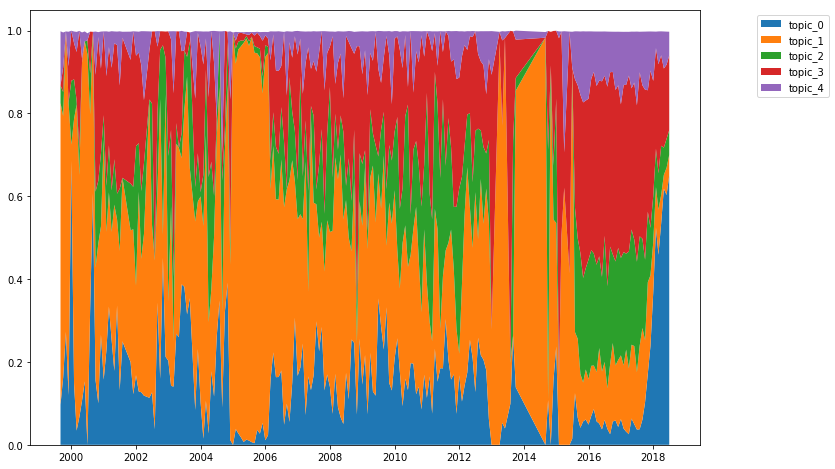

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [21]:
ldamodel1.print_topics()

[(0,
  '0.006*"модель" + 0.005*"the" + 0.005*"2018" + 0.005*"фотография" + 0.005*"женщина" + 0.004*"доллар" + 0.004*"платье" + 0.004*"американский" + 0.004*"одежда" + 0.004*"кардашьян"'),
 (1,
  '0.016*"автомобиль" + 0.008*"модель" + 0.006*"машина" + 0.006*"новый" + 0.005*"тысяча" + 0.004*"марка" + 0.004*"миллион" + 0.004*"доллар" + 0.004*"продажа" + 0.004*"километр"'),
 (2,
  '0.013*"дом" + 0.012*"бренд" + 0.009*"коллекция" + 0.007*"представить" + 0.007*"марка" + 0.006*"основать" + 0.006*"новый" + 0.006*"аромат" + 0.006*"модный" + 0.005*"французский"'),
 (3,
  '0.016*"коллекция" + 0.015*"бренд" + 0.013*"одежда" + 0.008*"представить" + 0.008*"обувь" + 0.008*"дизайнер" + 0.007*"марка" + 0.006*"модель" + 0.006*"аксессуар" + 0.005*"лента"'),
 (4,
  '0.026*"часы" + 0.015*"модель" + 0.010*"корпус" + 0.008*"часовой" + 0.007*"золото" + 0.007*"бренд" + 0.007*"швейцарский" + 0.006*"представить" + 0.006*"лента" + 0.006*"ру"')]

### Топ слова.

In [22]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [23]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [24]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

бренд - 7855 times.
коллекция - 6818 times.
модель - 6711 times.
одежда - 5475 times.
представить - 5209 times.
марка - 4604 times.
новый - 4500 times.
дом - 4180 times.
часы - 3660 times.
основать - 3568 times.
автомобиль - 3498 times.
лента - 3437 times.
ру - 3292 times.
дизайнер - 3033 times.
выпустить - 2752 times.
аксессуар - 2752 times.
обувь - 2681 times.
доллар - 2605 times.
модный - 2570 times.
продажа - 2522 times.
американский - 2500 times.
тысяча - 2322 times.
создать - 2054 times.
линейка - 1967 times.
поступить - 1959 times.
магазин - 1922 times.
цена - 1890 times.
итальянский - 1815 times.
the - 1797 times.
редакция - 1792 times.
мода - 1776 times.
s - 1751 times.
пресс-релиз - 1751 times.
кожа - 1656 times.
появиться - 1652 times.
британский - 1636 times.
директор - 1630 times.
дизайн - 1601 times.
французский - 1597 times.
новое - 1569 times.
войти - 1564 times.
россия - 1531 times.
производство - 1525 times.
новинка - 1505 times.
женский - 1502 times.
российский - 150